In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.version)
print(sys.version_info)

for module in mpl, np, pd, sklearn, tf, keras:
  print(module.__name__, module.__version__)

fashion_minst = keras.datasets.fashion_mnist

(x_train_all, y_train_all), (x_test, y_test) = fashion_minst.load_data()

x_valid, x_train = x_train_all = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# 归一化之前的最大和最小值
print(np.max(x_train), np.min(x_train))

# normalization
# x = (x - u) / std, u 是均值 std 是方差，使数据呈现均值为 0，方差为 1 的正态分布

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_valid_scaled = scaler.fit_transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

# 归一化之后的最大和最小值
print(np.max(x_train_scaled), np.min(x_train_scaled))

print('===============================')
print(x_train[0].size)
print('===============================')


<module 'tensorflow_core._api.v2.version' from '/opt/anaconda3/envs/tensorflow-2/lib/python3.7/site-packages/tensorflow_core/_api/v2/version/__init__.py'>
sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.3
pandas 0.25.2
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf
(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)
255 0
2.0231433 -0.8105136
784


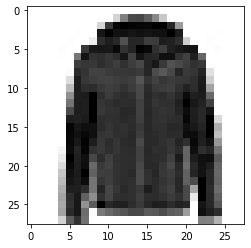

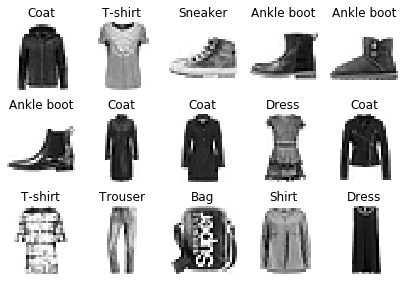

In [2]:
def show_single_image(img_arr):
  plt.imshow(img_arr, cmap="binary")
  plt.show()

def show_images(n_rows, n_cols, x_data, y_data, class_names):
  assert len(x_data) == len(y_data)
  assert n_rows * n_cols < len(x_data)
  plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
  for row in range(n_rows):
    for col in range(n_cols):
      index = n_cols * row + col
      plt.subplot(n_rows, n_cols, index + 1)
      plt.imshow(x_data[index], cmap="binary", interpolation = 'nearest')
      plt.axis('off')
      plt.title(class_names[y_data[index]])
  plt.show()

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']

# show single or multiple images
show_single_image(x_train[0])
show_images(3, 5, x_train, y_train, class_names)

# sequential
# 全连接层和激活函数
# relu, y = max(0, x)
# softmax, 将向量变成概率分布 x = [x1, x2, x3], y = [e^x1 / sum, e^x2 / sum, e^x3 / sum], sum = e^x1 + e^x2 + e^x3
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape = [28, 28]),
  keras.layers.Dense(300, activation="relu"),
  keras.layers.Dense(100, activation="relu"),
  keras.layers.Dense(10, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [5]:
# 查看模型层数和概况
# print(model.layers)
# print(model.summary())

# Tensorboard, earlystopping, ModelCheckpoint
logdir = './callbacks'

if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(
        output_model_file,
        save_best_only = True
    ),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]
history = model.fit(
    x_train_scaled,
    y_train, epochs=10,
    validation_data = (x_valid_scaled, y_valid),
    callbacks = callbacks
)

type(history)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 131us/sample - loss: 0.9109 - accuracy: 0.7029 - val_loss: 0.6056 - val_accuracy: 0.7968
Epoch 2/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.5712 - accuracy: 0.8042 - val_loss: 0.5188 - val_accuracy: 0.8210
Epoch 3/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.5081 - accuracy: 0.8233 - val_loss: 0.4786 - val_accuracy: 0.8376
Epoch 4/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.4730 - accuracy: 0.8344 - val_loss: 0.4560 - val_accuracy: 0.8414
Epoch 5/10
55000/55000 [==============================] - 7s 122us/sample - loss: 0.4499 - accuracy: 0.8417 - val_loss: 0.4363 - val_accuracy: 0.8512
Epoch 6/10
55000/55000 [==============================] - 7s 119us/sample - loss: 0.4329 - accuracy: 0.8479 - val_loss: 0.4247 - val_accuracy: 0.8546
Epoch 7/10
55000/55000 [===========================

tensorflow.python.keras.callbacks.History

In [ ]:
history.history

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [ ]:
plot_learning_curves(history)

In [ ]:
model.evaluate(x_test_scaled, y_test)